In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
% matplotlib inline

C:\Users\Rishi\Anaconda2\envs\cryprto2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def get_market_data(market, tag=True):
    """
     returns pandas data frame
    """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                            "/historical-data/?start=20160428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data

In [4]:
btc_data = get_market_data("bitcoin", tag="BTC")
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market Cap
0,2018-04-23,8794.39,8958.55,8788.81,8930.88,6925190000,149448000000
1,2018-04-22,8925.06,9001.64,8779.61,8802.46,6629900000,151651000000
2,2018-04-21,8848.79,8997.57,8652.15,8895.58,7548550000,150337000000
3,2018-04-20,8286.88,8880.23,8244.54,8845.83,8438110000,140777000000
4,2018-04-19,8159.27,8298.69,8138.78,8294.31,7063210000,138591000000


In [5]:
merge_date = '2016-01-01' 
def merge_data(a, b, from_date=merge_date):
    """
  returns merged pandas data frame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data

In [6]:
def add_volatility(data, coins=['BTC', 'ETH']):
     """
  This function calculates the volatility and close off high of each given coin
  each day and adds the result as new columns to the data frame
  returns data frame with added columns
  """
  for coin in coins:
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + 'close_off_high': lambda x: 2 * (x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + 'volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
    return data

In [7]:
def create_model_data(data):
    """
return the pandas dataframe
  """
  data = data[['Date'] + [coin + metric for coin in ['BTC_', 'ETH_'] for metric in ['Close', 'Volume']]]
  data = data.sort_values(by='Date')
  return data

In [8]:
def split_data(data, training_size = 0.8):
  return data[:int(training_size * len(data))], data[int(training_size * len(data)):]

In [9]:
window_len = 30
def create_inputs(data, coins=['BTC', 'ETH'], window_length=window_len):
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_length):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

In [10]:
def create_outputs(data, coin, window_length=window_len):
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1

In [11]:
def to_array(data):
  x = [np.array(data[i]) for i in range(len(data))]
  return np.array(x)

In [12]:
neurons = 1024
activation_function = 'tanh'
loss = 'mse'
optimizer='adam'
dropout = 0.25
batch_size = 128
epochs = 53
def build_model(inputs, output_size, neurons, activ_fun=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  model.add(LSTM(neurons, return_sequences = True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_fun))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [13]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(x_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(x_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(x_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [14]:
btc_data = get_market_data('bitcoin', tag='BTC')
etc_data = get_market_data('ethereum', tag='ETH')
btc_data.head()
etc_data.head()

,Date,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market Cap
0,2018-04-23,621.20,646.70,621.03,642.55,2386830000,61490600000
1,2018-04-22,606.12,640.77,593.87,621.86,2426270000,59985500000
2,2018-04-21,616.00,621.89,578.55,605.39,2612460000,60951100000
3,2018-04-20,567.99,618.72,560.28,615.72,2849470000,56188700000
4,2018-04-19,524.04,567.89,523.26,567.89,2256870000,51829900000


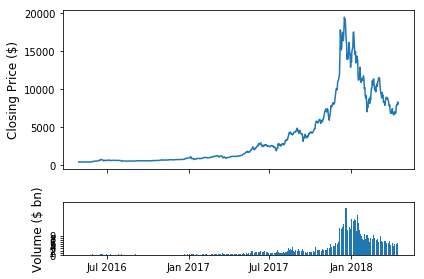

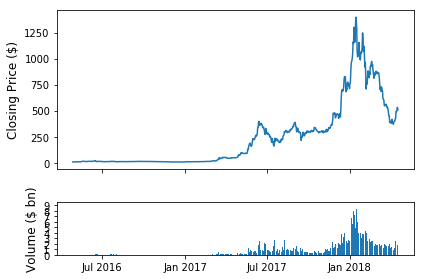

In [14]:
show_plot(btc_data, tag='BTC')
show_plot(etc_data, tag='ETH')

In [15]:
market_data = merge_data(btc_data, etc_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)
model_data.head()

,Date,BTC_Close,BTC_Volume,ETH_Close,ETH_Volume
719,2016-04-28,449.01,74064700,7.17,11576000
718,2016-04-29,455.10,49258500,7.46,8762080
717,2016-04-30,448.32,69322600,8.81,36573300
716,2016-05-01,451.88,40660100,8.85,16713800
715,2016-05-02,444.67,92127000,10.16,41019200


In [16]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

x_train = create_inputs(train_set)
y_train_btc = create_outputs(train_set, coin='BTC')
x_test = create_inputs(test_set)
y_test_btc = create_outputs(test_set, coin='BTC')
y_train_eth = create_outputs(train_set, coin='ETH')
y_test_eth = create_outputs(test_set, coin='ETH')
x_train, x_test = to_array(x_train), to_array(x_test)


In [17]:
gc.collect()
np.random.seed(202)
btc_model = build_model(x_train, output_size=1, neurons=neurons)
btc_history = btc_model.fit(x_train, y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 1024)          4214784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 1024)          8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 1024)          8392704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1024)              8392704   
__________

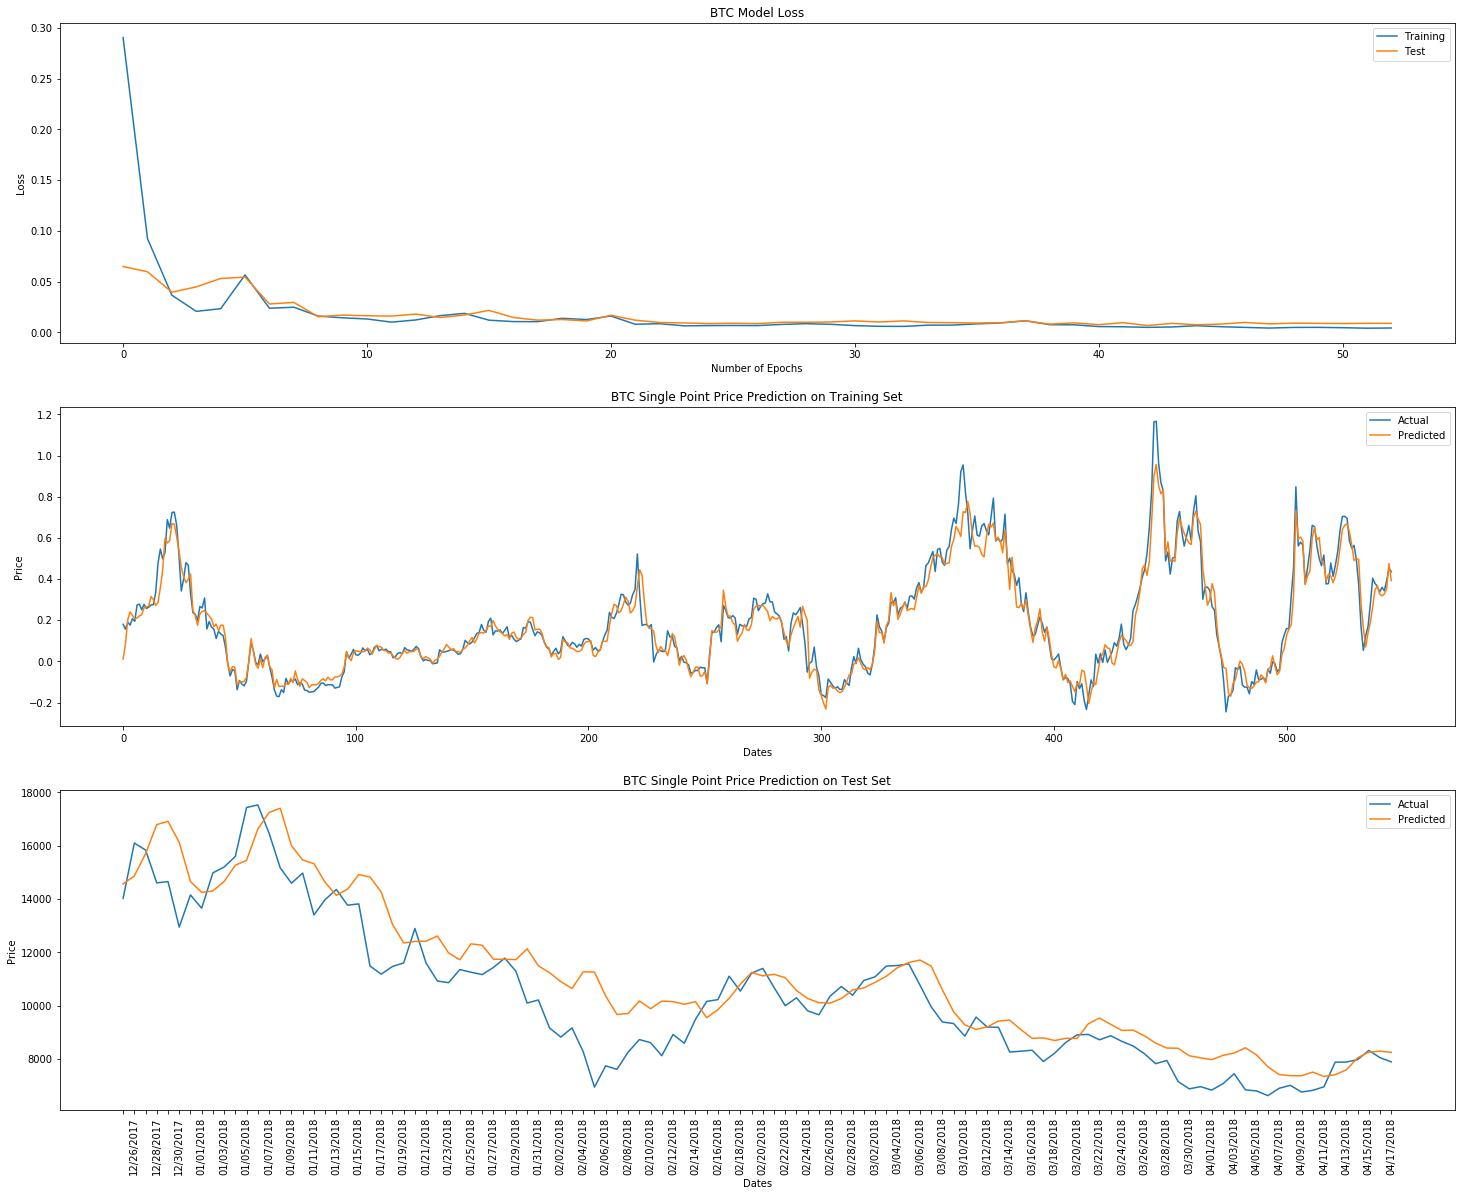

In [18]:
plot_results(btc_history, btc_model, y_train_btc, coin='BTC')